In [1]:
# This exercise aims to explore skills around time series analysis and visualisation in python
# The data being explored was obtained from Kaggle. 
# The data set contains over 4.5 million Uber pickups in New York City in 2014, 
# This exercise explores the application of few datetime series algorithims like ARIMA, etc.


# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium 
from folium.plugins import HeatMap

In [2]:
# ingest data by loading CSV into memory. 
# data source = https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city

def uber_2014():
    april14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-apr14.csv', header=0)
    may14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-may14.csv', header=0)
    june14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-jun14.csv', header=0)
    july14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-jul14.csv', header=0)
    august14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-aug14.csv', header=0)
    sep14 = pd.read_csv('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\uberData\\uber-raw-data-sep14.csv', header=0)

    merged_2014 = april14.append([may14, june14, july14, august14, sep14], ignore_index=True)
    return merged_2014

uberData = uber_2014()

uberData.sample(13)


,Date/Time,Lat,Lon,Base
3103108,8/15/2014 9:50:00,40.7806,-73.9558,B02617
4179282,9/4/2014 17:20:00,40.7535,-73.9982,B02682
3499953,8/30/2014 0:47:00,40.7137,-73.9927,B02764
1060173,5/10/2014 18:17:00,40.7175,-74.0106,B02682
2927229,8/31/2014 19:58:00,40.7188,-73.9908,B02598
1882354,7/2/2014 15:51:00,40.7515,-73.9937,B02512
3891957,9/9/2014 16:44:00,40.7406,-73.9904,B02617
171745,4/25/2014 18:01:00,40.7560,-73.9832,B02598
1924194,7/2/2014 8:06:00,40.7771,-73.9889,B02598
1294185,6/6/2014 12:24:00,40.7051,-74.0101,B02598


In [3]:
# Explorative Data Analysis and Visualisation

uberData.info() # uberData[Date/Time] needs to be pd.to_datetime format. Not object

# Convert uberData['Date/Time'] to time 
uberData['Date/Time'] = uberData['Date/Time'].map(pd.to_datetime)
uberData.sample(15)

# make uberData['Date/Time'] index [0]
uberDataT = uberData
uberDataT.set_index(['Date/Time'], inplace = False)
uberDataT.sample(15)

# check for missing data 
uberDataT.isnull().sample(15)
uberDataT.isnull().info()
uberDataT.isnull().describe()

# Extract hour, day and month from timeseries data
uberDataT.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
Date/Time    object
Lat          float64
Lon          float64
Base         object
dtypes: float64(2), object(2)
memory usage: 138.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
Date/Time    bool
Lat          bool
Lon          bool
Base         bool
dtypes: bool(4)
memory usage: 17.3 MB


,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512


In [4]:
def get_dom(dt):
    return dt.day
uberDataT['Day Of Month'] = uberDataT['Date/Time'].map(get_dom)

def get_weekday(dt):
    return dt.dayofweek
uberDataT['WeekDay'] = uberDataT['Date/Time'].map(get_weekday)

def get_hour(dt):
    return dt.hour
uberDataT['Hour'] = uberDataT['Date/Time'].map(get_hour)

def get_month(dt):
    return dt.month
uberDataT['Month'] = uberDataT['Date/Time'].map(get_month)

uberDataT.sample(15)

# Set index to date time in readiness for time series analysis.
uberDataT = uberDataT.set_index('Date/Time', inplace=False)
uberDataT.sample(15)

,Lat,Lon,Base,Day Of Month,WeekDay,Hour,Month
Date/Time,,,,,,,
2014-09-12 10:29:00,40.7699,-73.8644,B02598,12,4,10,9
2014-07-12 23:23:00,40.7213,-73.9877,B02617,12,5,23,7
2014-05-09 16:18:00,40.7617,-73.9787,B02617,9,4,16,5
2014-06-17 04:21:00,40.7444,-73.9917,B02598,17,1,4,6
2014-07-02 19:23:00,40.7313,-74.0026,B02682,2,2,19,7
2014-04-22 18:12:00,40.7261,-74.0096,B02682,22,1,18,4
2014-08-04 22:01:00,40.7319,-74.0035,B02682,4,0,22,8
2014-09-22 23:09:00,40.7593,-73.9792,B02682,22,0,23,9
2014-05-27 22:29:00,40.7350,-73.9751,B02598,27,1,22,5


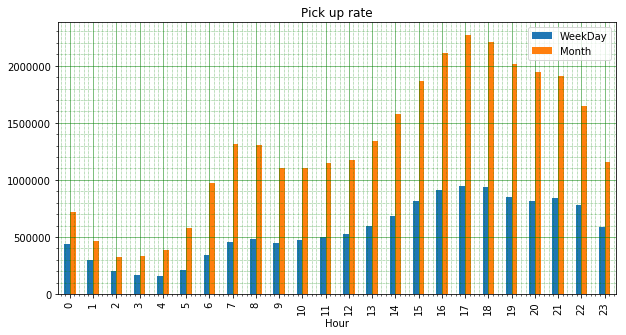

In [5]:
# Data Exploration.

# what is the outlook on pick up rate per hour
day_rate = uberDataT.groupby('Hour')
dayRate = day_rate.sum()

dayRate_perHour = dayRate[['WeekDay', 'Month']]
dayRate_perHour.head()

dayRate_perHour.plot(kind='bar',figsize=(10,5))
plt.title('Pick up rate') 

# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')
plt.show()

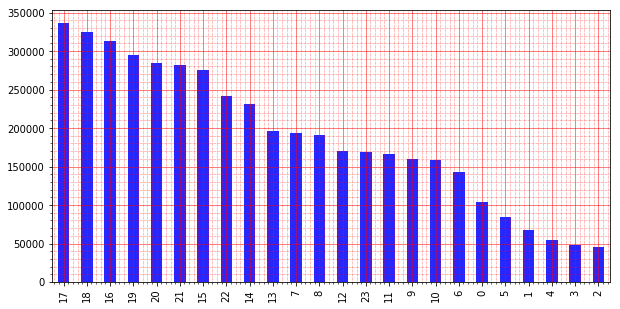

In [6]:
# which hour of the day has the most pick up rate
checkcount = uberDataT['Hour'].value_counts()
checkcount

checkcount.plot(kind='bar',figsize=(10,5), color='blue', alpha=0.85)
# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='red')

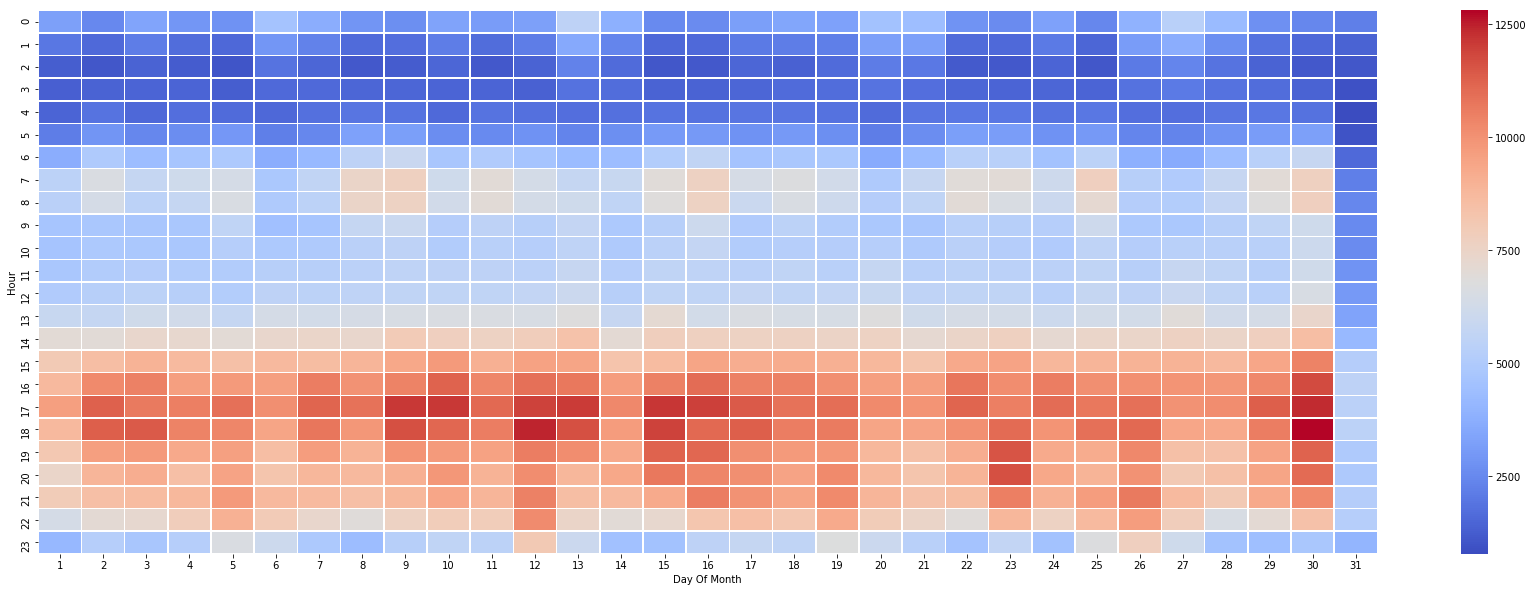

In [10]:
# what is the outlook of pick up rate the data presents
byDate = pd.crosstab(uberDataT['Hour'],uberDataT['Day Of Month'])
byDate
plt.figure(figsize= (30,10))
sns.heatmap(byDate, linewidth=.5, cmap='coolwarm', annot=False);


### FEATURE ENGINEERING - using domain knowledge of the data to create features that make machine learning algorithms work.




In [11]:

# Exploring data for cleansing and wrangling. 
uberData.info()
uberData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 8 columns):
Date/Time       datetime64[ns]
Lat             float64
Lon             float64
Base            object
Day Of Month    int64
WeekDay         int64
Hour            int64
Month           int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 276.8+ MB


,Lat,Lon,Day Of Month,WeekDay,Hour,Month
count,4.534327e+06,4.534327e+06,4.534327e+06,4.534327e+06,4.534327e+06,4.534327e+06
mean,4.073926e+01,-7.397302e+01,1.594337e+01,2.968115e+00,1.421831e+01,6.828703e+00
std,3.994991e-02,5.726670e-02,8.744902e+00,1.875971e+00,5.958759e+00,1.703810e+00
min,3.965690e+01,-7.492900e+01,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,4.072110e+01,-7.399650e+01,9.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00
50%,4.074220e+01,-7.398340e+01,1.600000e+01,3.000000e+00,1.500000e+01,7.000000e+00
75%,4.076100e+01,-7.396530e+01,2.300000e+01,5.000000e+00,1.900000e+01,8.000000e+00
max,4.211660e+01,-7.206660e+01,3.100000e+01,6.000000e+00,2.300000e+01,9.000000e+00


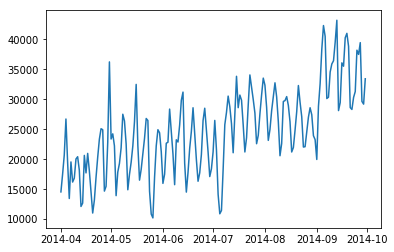

In [12]:
# compare pickup rates of different months

# Feature Engineering 2 - object oriented method of extracting useful columns from original data.
def create_day_series(uberData):
    
    # Grouping by Date/Time to calculate number of trips
    day_uberData = pd.Series(uberDataT.groupby(['Date/Time']).size())
    
    # setting Date/Time as index
    day_uberData.index = pd.DatetimeIndex(day_uberData.index)
    
    # Resampling to daily trips
    day_uberData = day_uberData.resample('1D').apply(np.sum)
    
    return day_uberData

day_uber2014 = create_day_series(uberData)
day_uber2014.head()

plt.plot(day_uber2014)

In [ ]:
# Visualise pick up rate via geographic representation
# ingest shape file for new york
nymap = gpd.read_file('C:\\Users\\Ibitoye\\OneDrive\\edX_DATA_SCIENCE\\miniProject\\NY_shapelyFILE\\geo_export_f406be96-9d42-4c64-afca-7f1a38b5d2d0.shp')

# plot shape file
fig, ax = plt.subplots(figsize=(15,15))
nymap.plot(ax=ax)

#plot district
distric_map = folium.Map(location=[42.5, -75.5], zoom_start=7, tiles='cartodbpositron' )
print('default map crs: ',distric_map.crs)

# convert it to the projection of our folium openstreetmap
nymap = distric_map.to_crs({'init':'epsg:3857'})

#show plot
folium.GeoJson(nymap).add_to(distric_map)
distric_map


max_amount = float(uberDataT['Month'].max())

hmap = folium.Map(location=[42.5, -75.5], zoom_start=7, )

hm_wide = HeatMap( list(zip(uberDataT.lat.values, uberData.lon.values, uberDataT.Month.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

folium.GeoJson(distric_map).add_to(hmap)
hmap.add_child(hm_wide)

p-value: 0.8458980824898368


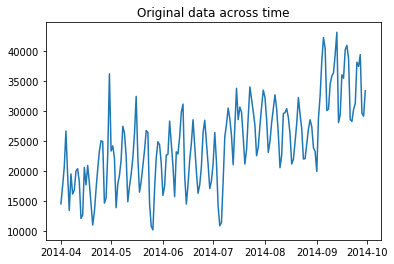

<Figure size 432x288 with 0 Axes>

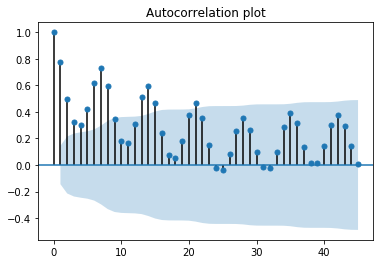

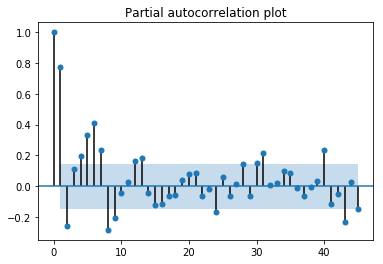

In [13]:
# ARIMA

# Before going any further into the analysis, the series has to be made stationary.
# Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). 
# If the mean of a time-series increases over time, then it’s not stationary.

#Checking trend and autocorrelation
def initial_plots(day_uber2014, num_lag):

    #Original timeseries plot
    plt.figure(1)
    plt.plot(day_uber2014)
    plt.title('Original data across time')
    plt.figure(2)
    #Autocorrelation plot
    plot_acf(day_uber2014, lags = num_lag)
    plt.title('Autocorrelation plot')
    #Partial Autocorrelation plot
    plot_pacf(day_uber2014, lags = num_lag)
    plt.title('Partial autocorrelation plot')
    
    plt.show()

    
#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(day_uber2014)[1]))

#plotting
initial_plots(day_uber2014, 45)


#Defining RMSE
def rmse(x,y):
    return sqrt(mean_squared_error(x,y))

In [14]:
#fitting ARIMA model on dataset
def SARIMAX_call(day_uber2014,p_list,d_list,q_list,P_list,D_list,Q_list,s_list,test_period):    
    
    #Splitting into training and testing
    training_ts = day_uber2014[:-test_period]
    
    testing_ts = day_uber2014[len(day_uber2014)-test_period:]
    
    error_table = pd.DataFrame(columns = ['p','d','q','P','D','Q','s','AIC','BIC','RMSE'],\
                                                           index = range(len(ns_ar)*len(ns_diff)*len(ns_ma)*len(s_ar)\
                                                                         *len(s_diff)*len(s_ma)*len(s_list)))
    count = 0
    
    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            for s in s_list:
                                #fitting the model
                                SARIMAX_model = SARIMAX(training_ts.astype(float),\
                                                        order=(p,d,q),\
                                                        seasonal_order=(P,D,Q,s),\
                                                        enforce_invertibility=False)
                                SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
                                AIC = np.round(SARIMAX_model_fit.aic,2)
                                BIC = np.round(SARIMAX_model_fit.bic,2)
                                predictions = SARIMAX_model_fit.forecast(steps=test_period,typ='levels')
                                RMSE = rmse(testing_ts.values,predictions.values)                                

                                #populating error table
                                error_table['p'][count] = p
                                error_table['d'][count] = d
                                error_table['q'][count] = q
                                error_table['P'][count] = P
                                error_table['D'][count] = D
                                error_table['Q'][count] = Q
                                error_table['s'][count] = s
                                error_table['AIC'][count] = AIC
                                error_table['BIC'][count] = BIC
                                error_table['RMSE'][count] = RMSE
                                
                                count+=1 #incrementing count        
    
    #returning the fitted model and values
    return error_table

ns_ar = [0,1,2]
ns_diff = [1]
ns_ma = [0,1,2]
s_ar = [0,1]
s_diff = [0,1] 
s_ma = [1,2]
s_list = [7]

error_table = SARIMAX_call(day_uber2014,ns_ar,ns_diff,ns_ma,s_ar,s_diff,s_ma,s_list,30)


# printing top 5 lowest RMSE from error table
error_table.sort_values(by='RMSE').head(5)


C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differe

C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequ

C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Ibitoye\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creat

,p,d,q,P,D,Q,s,AIC,BIC,RMSE
5,0,1,0,1,0,2,7,2903.32,2915.42,5061.76
3,0,1,0,0,1,2,7,2752.78,2761.71,5105.3
7,0,1,0,1,1,2,7,2754.8,2766.7,5136.57
6,0,1,0,1,1,1,7,2754.5,2763.43,5278.11
2,0,1,0,0,1,1,7,2752.71,2758.66,5336.34


p-value: 1.516364117743573e-08


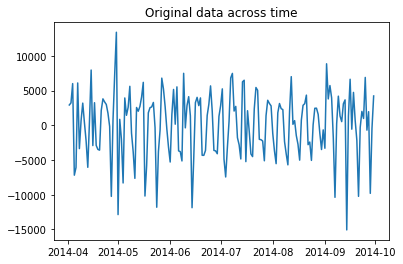

<Figure size 432x288 with 0 Axes>

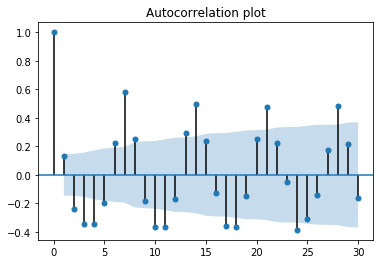

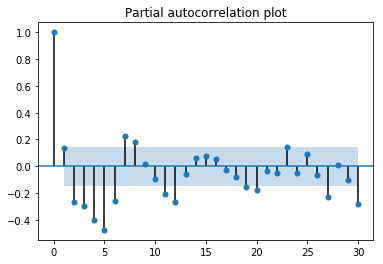

In [15]:
#storing differenced series
diff_series = day_uber2014.diff(periods=1)

#Augmented Dickey-Fuller test for stationarity
#checking p-value
print('p-value: {}'.format(adfuller(diff_series.dropna())[1]))


initial_plots(diff_series.dropna(), 30)

In [34]:
# printing top 5 lowest RMSE from error table
error_table.sort_values(by='RMSE').head(5)

,p,d,q,P,D,Q,s,AIC,BIC,RMSE
5,0,1,0,1,0,2,7,2903.32,2915.42,5061.76
3,0,1,0,0,1,2,7,2752.78,2761.71,5105.3
7,0,1,0,1,1,2,7,2754.8,2766.7,5136.57
6,0,1,0,1,1,1,7,2754.5,2763.43,5278.11
2,0,1,0,0,1,1,7,2752.71,2758.66,5336.34
